<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [172]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [173]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [174]:
timesteps = int(len(df) * 0.66)
df_train, df_test = df[0:-timesteps], df[-timesteps:]

# Check size
print(df_train.shape)  
print(df_test.shape) 

(1294, 9)
(2511, 9)


In [175]:
model = VAR(df_train)
for i in range(0,12):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0
AIC :  38.38352704306933
BIC :  38.41945396832091
FPE :  4.674702656984103e+16
HQIC:  38.39701002975742 

Lag Order = 1
AIC :  20.157751505875268
BIC :  20.517244803701615
FPE :  568069473.4212288
HQIC:  20.29267062901131 

Lag Order = 2
AIC :  19.892696324393512
BIC :  20.57615985614473
FPE :  435809338.60654485
HQIC:  20.149212482571976 

Lag Order = 3
AIC :  19.75432592602932
BIC :  20.762164378773978
FPE :  379508349.8235845
HQIC:  20.132600355861335 

Lag Order = 4
AIC :  19.682351533741315
BIC :  21.014970422593603
FPE :  353181687.83354944
HQIC:  20.182545810822774 

Lag Order = 5
AIC :  19.722639764399993
BIC :  21.380445434855247
FPE :  367749537.9184092
HQIC:  20.344915804283154 

Lag Order = 6
AIC :  19.745397657848997
BIC :  21.728797288127588
FPE :  376287997.02773297
HQIC:  20.48991771701764 

Lag Order = 7
AIC :  19.771591961473167
BIC :  22.08099356487283
FPE :  386379608.86649764
HQIC:  20.63851863832125 

Lag Order = 8
AIC :  19.81343156057229
BIC :  22.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [176]:
model_fitted = model.fit(4)

In [177]:
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]

In [178]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=timesteps)
df_forecast = pd.DataFrame(fc, index=df.index[-timesteps:], columns=df.columns + '_4_steps')
df_forecast

,% Silica Feed_4_steps,Amina Flow_4_steps,Flotation Column 01 Air Flow_4_steps,Flotation Column 03 Air Flow_4_steps,Flotation Column 04 Air Flow_4_steps,Flotation Column 02 Level_4_steps,Flotation Column 03 Level_4_steps,% Iron Concentrate_4_steps,% Silica Concentrate_4_steps
dates,,,,,,,,,
2017-05-07 14:00:00,23.948840,452.954252,249.481227,249.616067,299.920955,467.843539,454.780932,66.242178,2.430867
2017-05-07 14:20:00,23.327646,454.194455,250.497558,250.478636,299.941432,471.151077,465.331938,66.024573,2.547951
2017-05-07 14:50:00,22.749260,449.141957,249.609535,249.721557,299.948362,482.290119,468.908293,65.802988,2.697936
2017-05-07 15:00:00,22.197444,448.086227,248.880493,249.138775,299.949257,490.839794,479.251165,65.605568,2.797428
2017-05-07 15:10:00,21.652987,445.119038,248.702009,248.963617,299.968019,496.503018,486.737675,65.447789,2.885034
...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,15.622120,506.961636,256.062222,256.464201,299.355654,565.368194,573.841466,64.190651,3.500336
2017-09-09 20:00:00,15.622119,506.961624,256.062211,256.464190,299.355651,565.368255,573.841520,64.190651,3.500335
2017-09-09 21:00:00,15.622117,506.961612,256.062199,256.464179,299.355648,565.368315,573.841575,64.190651,3.500335


In [179]:
def format_dataframe(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_4_steps']
    return df_fc

df_results = format_dataframe(df_train, df_forecast)        

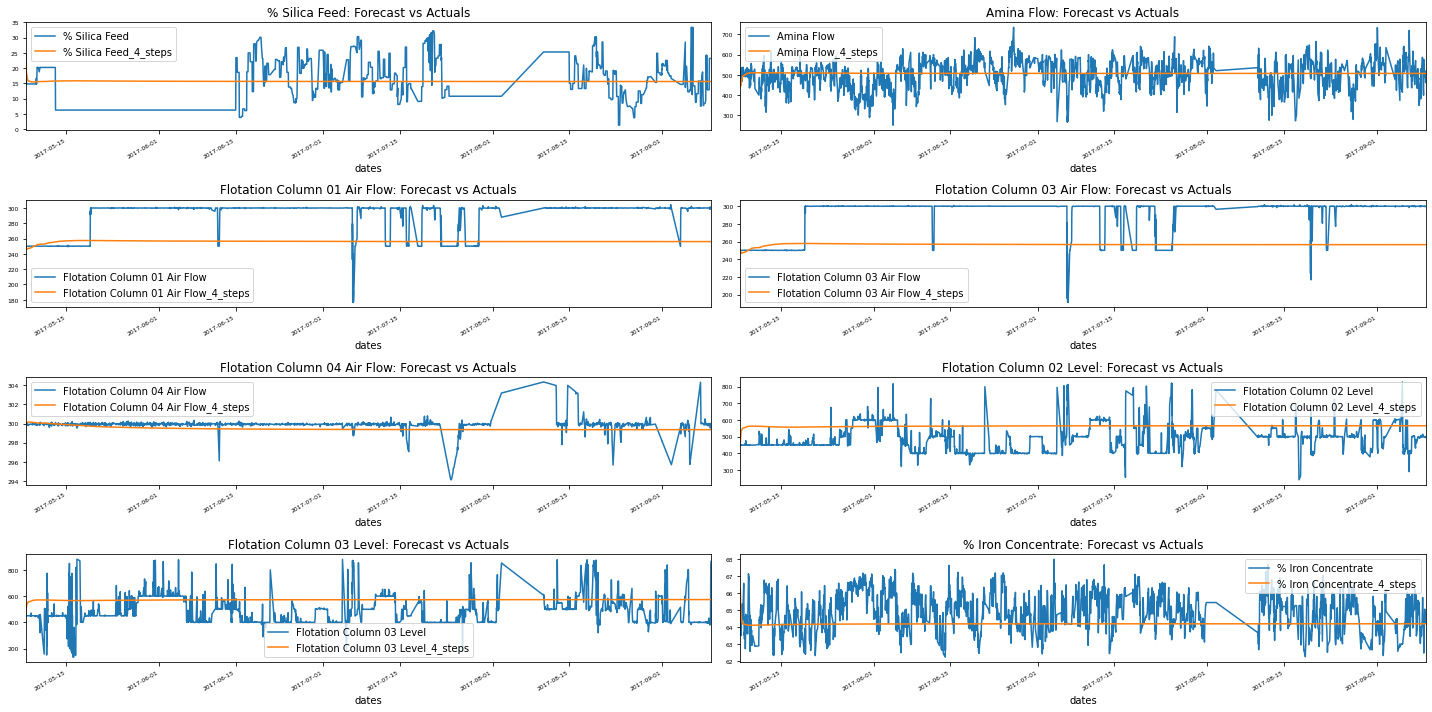

In [180]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, figsize=(20,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):

    df_test[col].plot(legend=True, ax=ax)
    df_forecast[col+'_4_steps'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)

    ax.set_title(col + ": Forecast vs Actuals")
    ax.tick_params(labelsize=6)

plt.tight_layout();

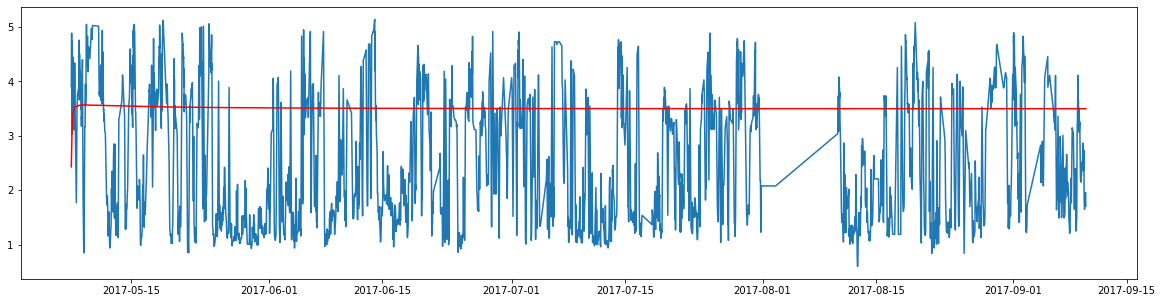

In [181]:
from sklearn.metrics import mean_squared_error
from math import sqrt

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
plt.plot(df_test['% Silica Concentrate'])
plt.plot(df_forecast['% Silica Concentrate_4_steps'], color='red')
plt.show()

In [182]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return({'mape':mape, 'mae': mae, 'rmse':rmse})

In [183]:
for col in df.columns:
  print('Forecast Accuracy of: ', col)
  accuracy_prod = forecast_accuracy(df_results[col+'_4_steps'].values, df_test[col])
  print(accuracy_prod, '\n')

Forecast Accuracy of:  % Silica Feed
{'mape': 0.7359044581491307, 'mae': 6.7307242303125046, 'rmse': 7.651180750221517} 

Forecast Accuracy of:  Amina Flow
{'mape': 0.12459449296119739, 'mae': 57.67555191326243, 'rmse': 72.31348266343086} 

Forecast Accuracy of:  Flotation Column 01 Air Flow
{'mape': 0.11862839365956067, 'mae': 35.09590185348302, 'rmse': 38.59619046746739} 

Forecast Accuracy of:  Flotation Column 03 Air Flow
{'mape': 0.1193795426870127, 'mae': 35.37188296819949, 'rmse': 38.516011678114246} 

Forecast Accuracy of:  Flotation Column 04 Air Flow
{'mape': 0.0026165094084259397, 'mae': 0.7855180746003201, 'rmse': 1.3164584734612954} 

Forecast Accuracy of:  Flotation Column 02 Level
{'mape': 0.2136748440055853, 'mae': 95.58584915067877, 'rmse': 109.06251550675245} 

Forecast Accuracy of:  Flotation Column 03 Level
{'mape': 0.27515299059281284, 'mae': 118.90097716063174, 'rmse': 137.59375842507836} 

Forecast Accuracy of:  % Iron Concentrate
{'mape': 0.016178139296160344, '